In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import datasets, transforms, models


import numpy as np

import matplotlib.pyplot as plt
from tqdm import tqdm

from IPython.display import clear_output

from evaluation import knn_evaluation

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
# class SimCLRDataset(Dataset):
#     def __init__(self, dataset, transform, num_positives):
#         """
#         Args:
#             dataset: Base dataset (e.g., CIFAR-10)
#             transform: Transformation pipeline for data augmentation
#             num_positives: Number of positive samples to generate per anchor
#         """
#         self.dataset = dataset
#         self.transform = transform
#         self.num_positives = num_positives

#     def __len__(self):
#         return len(self.dataset)

#     def __getitem__(self, idx):
#         # Get the anchor image and its label
#         img, label = self.dataset[idx]
        
#         anchor = self.transform(img)
#         # Apply transformations to generate positive samples
#         positives = [self.transform(img) for _ in range(self.num_positives)]

#         return anchor, torch.stack(positives), label
    
    

class SimCLRDataset(Dataset):
    def __init__(self, dataset, transform, num_positives):
        """
        Args:
            dataset: Base dataset (e.g., CIFAR-10)
            transform: Transformation pipeline for data augmentation
            num_positives: Number of positive samples to generate per anchor
        """
        self.dataset = dataset
        self.transform = transform
        self.num_positives = num_positives

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        # Get the anchor image and its label
        img, label = self.dataset[idx]
        
        anchor1 = self.transform(img)
        anchor2 = self.transform(img)

        # Apply transformations to generate positive samples
        positives = [self.transform(img) for _ in range(self.num_positives)]

        return [anchor1, anchor2], positives, label

In [4]:
# CIFAR-10 dataset
cifar10_train = datasets.CIFAR10(
    root="./dataset/cifar10",
    train=True,
    download=True,
)

# Transformation pipeline for data augmentation
transform = transforms.Compose([
    transforms.RandomResizedCrop(size=32),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomApply([transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1)], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor(),
])

Files already downloaded and verified


In [5]:
class ResNet18Encoder(nn.Module):
    def __init__(self, projection_dim):
        super(ResNet18Encoder, self).__init__()
        # Load pre-trained ResNet18 and remove the fully connected layer
        self.encoder = models.resnet18(weights=None)
        self.encoder = nn.Sequential(*list(self.encoder.children())[:-1])
        
        # Add a projection head
        self.projection_head = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, projection_dim)
        )

    def forward(self, x):
        # Forward pass through ResNet18 encoder
        features = self.encoder(x)
        features = torch.flatten(features, start_dim=1)  # Flatten the output
        # Forward pass through the projection head
        projections = self.projection_head(features)
        
        # projections = projections / projections.norm(dim=0)
        projections = nn.functional.normalize(projections, p=2, dim=1)
        
        return projections


In [6]:
def get_negative_mask(batch_size):
    negative_mask = torch.ones((batch_size, 2 * batch_size), dtype=bool)
    for i in range(batch_size):
        negative_mask[i, i] = 0
        negative_mask[i, i + batch_size] = 0

    negative_mask = torch.cat((negative_mask, negative_mask), 0)
    return negative_mask



def AttentioNCE(out_1, out_2, out_pos, batch_size, temperature=0.5, d_pos=1., d_neg=1.):
    '''
    Parameters
    ----------
    # anchor points
    out_1 : anchor features [bs,dim]
    out_2 : anchor features [bs,dim]

    # 4 positive views for  each anchor point 
    out_3 : positive view1 features [bs,dim]
    out_4 : positive view2 features [bs,dim]
    out_5 : positive view3 features [bs,dim]
    out_6 : positive view4 features [bs,dim]

    batch_size : Under SimCLR framework, negative sample size N = 2 x (batch size - 1)
    temperature: temperature scaling
    d_pos : positive scaling factor
    d_neg : negative scaling factor
    Returns: AttentioNCE loss values [2bs,]
    -------
    '''
    
    feature_dim = 128
    num_pos = len(out_pos)
    
    anchor = torch.cat([out_1, out_2], dim=0)  # [2bs*dim]

    # pos score
    pos_views = torch.cat(out_pos,dim=1).view(-1, num_pos, feature_dim) # [bs,num_pos,dim]
    pos_sim = torch.sum(anchor.view(2, batch_size, 1, feature_dim) * pos_views, dim=-1).view(-1, num_pos)
    # [2,bs,1,dim] x [bs,num_pos,dim]  -> [2,bs,num_pos,dim] ->  [2,bs,num_pos]-> [2bs,num_pos]
    alpha = torch.nn.functional.softmax(pos_sim.detach()/ d_pos, dim=-1) # [2bs,num_pos]
    pos_score = torch.exp(torch.sum(pos_sim * alpha, dim=-1) / temperature)  # [2bs,] This step is obtained based on the additivity property of inner product operations.

    # neg score
    sim = torch.mm(anchor, anchor.t().contiguous())  # [2bs,2bs]
    mask = get_negative_mask(batch_size).to(device)
    neg_sim = sim.masked_select(mask).view(2 * batch_size, -1)  # [2bs, 2bs-2]
    beta = (torch.nn.functional.softmax(neg_sim.detach() / d_neg, dim=-1) + 1e-6) * (2 * batch_size - 2)
    neg_score = torch.exp(neg_sim * beta / temperature)  # [2bs, 2N-2] This step is obtained based on the additivity property of inner product operations.

    # contrastive loss
    loss = - torch.log(pos_score / (pos_score + neg_score.sum(dim=-1))).mean() # [2bs,]
    return loss

In [19]:
n_pos = 5
projection_dim = 128
n_anchors = 256
epochs = 400

In [20]:
simclr_dataset = SimCLRDataset(cifar10_train, transform, n_pos)
data_loader = DataLoader(simclr_dataset, batch_size=n_anchors, shuffle=True, drop_last=True)

In [21]:
encoder = ResNet18Encoder(projection_dim).to(device)
# optimizer = torch.optim.Adam(encoder.parameters(), lr=1e-3, weight_decay=1e-6)
optimizer = torch.optim.Adam(encoder.parameters(), lr=1e-3)
# criterion = AttentionNCE(
#     n_anchors=n_anchors,
#     dim=projection_dim,
#     n_pos=n_pos,
#     temperature=1.
# )

losses = []
accs = []

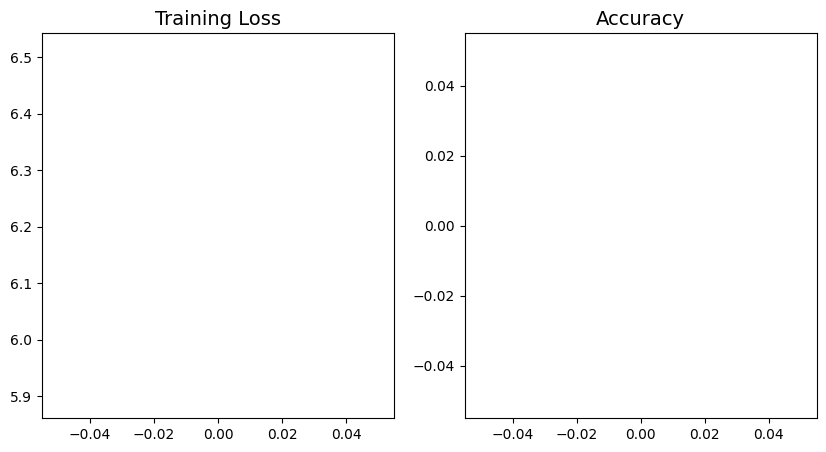

Epoch 0:   6%|▌         | 11/195 [00:06<01:52,  1.63it/s]


KeyboardInterrupt: 

In [22]:

for epoch in range(epochs):
    for n_step, (anchors, positives, labels) in tqdm(enumerate(data_loader), total=len(data_loader), desc=f'Epoch {epoch}'):
    # for iter, (anchors, positives, labels) in enumerate(data_loader):
        
        
        # x = torch.concat((anchor.unsqueeze(1), positives), dim=1)
        # x = x.reshape(n_anchors + n_anchors*n_pos, 3, 32, 32)
        
        anchor1, anchor2 = anchors
        
        anchor1 = anchor1.to(device)
        anchor2 = anchor2.to(device)
        
        out_1 = encoder(anchor1)
        out_2 = encoder(anchor2)
        out_pos = []
        for pos in positives:
            out = encoder(pos.to(device))
            out_pos.append(out)
        
        loss = AttentioNCE(out_1, out_2, out_pos, batch_size=n_anchors)
        # loss, pos_terms, neg_terms, scores = criterion(q, k)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        
        
        # print(loss)
        # print()
        
        if n_step % (len(data_loader)//10) == 0 or n_step == len(data_loader)-1:
            clear_output(True)
            fig, axs = plt.subplots(1, 2, figsize=(10, 5))
            axs[0].plot(losses)
            axs[0].set_title('Training Loss', fontsize=14)
            axs[1].plot(accs)
            axs[1].set_title('Accuracy', fontsize=14)
            plt.show()
        
        # break
        
    acc = knn_evaluation(encoder, dataset='cifar10')
    accs.append(acc)